# Ommatidia optics and lamina circuitry
- Why does the *Megaphragma* eye have two distinct sets of ommatidia? How might visual information from these regions differ?
- Which aspects of the lamina circuit reflect optical variability in the retina? What does this say about the function of these types of connections?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import statsmodels.api as sm
import itertools

import sys
from cx_analysis.utils import index_by_om
from cx_analysis.dataframe_tools import assemble_cxvectors, extract_connector_table
from vis.fig_tools import linear_cmap, subtype_cm
from vis.hex_lattice import hexplot_TEST, hexplot

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

cm = subtype_cm()

In [3]:
### SAVE FIGS? ###
savefigs=False
savepath = '/mnt/home/nchua/Dropbox/lamina_figures/'
##################
#if save_figs:
#    fig.savefig(savepath + 'FNAME.svg')
#    fig.savefig(savepath + 'FNAME.png')

### Optical measurements

In [4]:
optics_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)
optics_df = optics_df.iloc[:29] # remove last two lines of excel file
optics_df.index.rename('om')


display(optics_df.loc['A3'])
display(optics_df.mean())

facet diameter (stack)              9.24715
lense thickness                      3.4074
outer curvature                     4.98901
inner curvature                     3.01126
cone length (from the tip)          4.67152
cone width (under the lense tip)    6.78884
D rhabdom dist.                     2.23684
D rhabdom prox.                     2.30169
Name: A3, dtype: object

facet diameter (stack)              7.641780
lense thickness                     3.013373
outer curvature                     4.201836
inner curvature                     2.416195
cone length (from the tip)          4.071292
cone width (under the lense tip)    6.038509
D rhabdom dist.                     2.491623
D rhabdom prox.                     1.892059
dtype: float64

In [5]:
# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rb_len = pd.read_pickle('~/Dropbox/Data/201123_rh_len_df.pickle')
for i, v in rb_len.iterrows():
    optics_df.loc[i, 'rhabdom_len'] = float(v)

# Rhabdomere vols from Anastasia: trying be consistent rb = rhabdomere, Rbd = Rhabdom
rb = pd.read_csv('~/Data/lamina_additional_data/ret_cell_vol.csv').set_index('rtype').T
rb.index.name = 'om'
rb = rb.loc[sorted(rb.index), sorted(rb.columns)]
rb_frac = (rb.T/rb.sum(axis=1)).T.rename(mapper={'vol': 'fvol'}, axis=1)

### Lamina connectome

In [6]:
tp = '200914'
data_path = f'~/Data/{tp}_lamina/{tp}_linkdf.pickle'
link_df = pd.read_pickle(data_path)  # connectivity data longform 
cxvecs = assemble_cxvectors(link_df)
cxs_before = len(cxvecs.columns)
cxvecs.index.rename('om')

Index(['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5',
       'B6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'E4', 'E5', 'E6', 'E7'],
      dtype='object', name='om')

In [7]:
# Filter inconsistently observed connection types
display(f"Number of connections observed (all): {cxs_before}")
mean_thresh = 0.5
cxvecs = cxvecs.loc[:, cxvecs.mean() >= mean_thresh]
display(f"Number of connections observed (where mean count >= {mean_thresh}): {len(cxvecs.columns)}")

# Filter out connectivity between cartridges
only_home_connections = False
if only_home_connections:
    cxvecs = cxvecs.loc[:, [i for i in cxvecs.columns if ('eLMC_4' not in i) and ('eLMC_2' not in i)]]
    display(f"Number of connections after removing inter-ommatidial: {cxs_before}")
    
ct_df = extract_connector_table(link_df) # DataFrame of connectors (presyn terminals)

'Number of connections observed (all): 161'

'Number of connections observed (where mean count >= 0.5): 63'

In [8]:
prtypes = rb.columns
subtypes = np.unique([*link_df['post_type'], *link_df['pre_type']])
ommatidia = np.unique(link_df['pre_om'])

In [9]:
ct_df.loc[:, 'pre_subtype'] = [v.split('_')[1] for i, v in ct_df['pre_neuron'].items()]

ct_df.loc[:, 'n_contacts'] = ct_df.filter(items=subtypes).sum(axis=1).rename('n_contacts')

ct_df.loc[ct_df['pre_om'] == 'C2']

,pre_om,pre_type,pre_neuron,LMC_1,LMC_2,LMC_3,LMC_4,LMC_N,R1R4,R2R5,R3R6,R7,R7p,R8,UNKNOWN,centri,post_om,pre_subtype,n_contacts
268735,C2,centri,omC2_centri_nc,0,0,0,0,0,0,0,0,0,2,2,0,1,C2,centri,5.0
451462,C2,centri,omC2_centri_nc,1,0,1,1,0,0,2,0,0,1,0,0,0,C2,centri,6.0
451565,C2,R2R5,omC2_R2_nc,1,2,0,1,0,0,1,0,0,1,0,0,2,multi,R2,8.0
451577,C2,centri,omC2_centri_nc,0,0,0,0,0,0,1,0,0,2,1,0,0,C2,centri,4.0
451597,C2,centri,omC2_centri_nc,0,1,0,0,0,0,1,0,0,1,1,0,0,C2,centri,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479890,C2,centri,omC2_centri_nc,1,0,0,0,0,0,0,0,0,1,0,0,1,C2,centri,3.0
479967,C2,centri,omC2_centri_nc,1,0,0,0,0,1,1,0,0,1,0,0,1,C2,centri,5.0
480005,C2,LMC_N,omC2_LN_nc,1,1,0,0,0,0,0,0,0,0,0,0,0,C2,LN,2.0
481428,C2,R1R4,omC2_R1_nc,1,4,3,1,0,0,0,0,0,0,0,0,1,multi,R1,10.0


In [10]:
data = []#dict.fromkeys(ct_df['pre_neuron'].unique())
neurons = []
for pre, rows in ct_df.groupby('pre_neuron'):
    if rows['pre_subtype'][0][0] != 'R':
        continue
    else:
        if pre[-2:] == 'nc':
            pre = pre[0: -3]
            print(pre)
        neurons.append(pre)
        data.append({'pre_subtype': rows['pre_subtype'][0],
                     'pre_om': rows['pre_om'][0], 
                     'n_out_terms': len(rows),
                     'n_out_syn': rows['n_contacts'].sum()})
r_out = pd.DataFrame(data, index=neurons)
#r1_6_syn.reset_index(index='pre_neuron')


omC2_R1
omC2_R2
omC2_R3
omC2_R4
omC2_R5
omC2_R6


In [11]:
# Specifies colors for DRA and non-DRA ommatidia
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]

def om_colors(om_list):
    c_list = []
    for o in ommatidia:
        if str(o) in dra_om:
            c_list.append('darkviolet')
        else:
            c_list.append('darkgreen')
    return c_list

## Lens calculations
### Measurements (all $\mu{m}$)
- Lens: Outer radius of curvature, $r_1$
- Lens: Inner radius of curvature, $r_2$
- Lens: thickness, $t$
- Lens: diameter, $D$
- Rhabdom: distal diameter, $D_{Rh}$
- Rhabdom: length, $l_{Rh}$
- Measurements also taken for the length and distal width of the crystalline cone, and the proximal diameter of the rhabdom (not used for the following calculations) 

### Calculations
- We used the refractive indices of the honey bee lens ($n_l$) and crystalline cone ($n_c$), from Valera & Wiitanen (1970)
- Optical power ($\mu{m}^{-1}$) of the diopteric apparatus (lens + crystalline cone), $P$, calculated using the thick lens formula (Fundamentals of Optics, Jenkins & White, p.84, 2001): 
$$P = P_1 + P_2 - \frac{t}{n_l} P_1 P_2$$
    - $P_1 = \frac{n_l - 1.0}{r_1}$, power from outer lens surface
    - $P_2 = \frac{n_c - n_l}{r_2}$, power from inner lens surface  
- Focal length of the object ($\mu{m}$): $f = 1/P$
- Focal length of the image ($\mu{m}$): $f' = {n_c}/P$
- F-number: $F = f/D$
- The acceptance angle of an ommatidium, $\Delta\rho$, is proscribed by diffraction effects at the lens,  $\Delta\rho_l$, and the geometry of the distal rhabdom tip and the lens, $\Delta\rho_{Rh}$ (Snyder, 1979):
$$\Delta\rho = \sqrt{{\Delta\rho_l}^2 + {\Delta\rho_{Rh}}^2}$$
    - $\Delta\rho_l = \lambda/D$, where we set $\lambda$ = 0.5 $\mu{m}$ (green monochromatic light)
    - $\Delta\rho_{Rh} = D_{Rh}/f$
- Optical sensitivity to an extended broadband-spectrum source, $S$ ($\mu{m}^2{sr}$), approximated by:  
$$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$$
    - See [Fredriksen and Warrant, 2008](https://dx.doi.org/10.1098%2Frsbl.2008.0467); [Kirschfeld, 1974](https://doi.org/10.1515/znc-1974-9-1023)
    - k is the peak absorbtion (length) coefficient of the visual pigment, taken as 0.0067 $\mu{m}^-1$ (Warrant et al., 2004)
    - Notes: facet area is $\frac{\pi{D}^2}{4}$, the fraction of incident light absorbed is $\frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$



In [13]:
r1 = optics_df['outer curvature']
r2 = -1 * optics_df['inner curvature']
t = optics_df['lense thickness']
D = optics_df['facet diameter (stack)'].astype('float')
Dr = optics_df['D rhabdom dist.']
lr = optics_df['rhabdom_len']

# Refractive indices from Apis mellifera (Varela & Wiitanen 1970)
# n = 1 # air
nl = 1.452 # lens
nc = 1.348 # cone
# lens power IN MICROMETERS
p1 = (nl - 1.0)/r1 # interface air->lens 
p2 = (nc - nl)/r2 # interface lens->cone
p = p1 + p2
# lens power: thick lens equation
# p3 = (t/nl)*p1*p2  # thickness 'correction'
# p_thick = p1 + p2 - p3
# Focal length object and image (n/p)
f = 1.0/(p)
fi = nc/(p)
# Focal length (thick lens eq, total_p = p1+p2-p3)
# f_t = 1.0/p_thick
# fi_t = nc/p_thick
# F-number (ratio of lens diameter to focal length)
F = D/f
# Acceptance angle
rho_l = 0.5/D # angular sens. due to diffraction at the lens, lambda=0.5
rho_rh = Dr/f # angular sens. due to geometry of rhabdom tip
# 'simple' acceptance angle formula 
rho = (rho_l ** (2.0) + rho_rh ** (2.0)) ** (0.5)

# Optical sensitivity
k = 0.0067 # peak absorbtion coefficient (wrt rhabdom length) from Warrant et al., 2004
kl = k * lr
S = ((np.pi / 4.0)**2.0) * (D ** 2.0) * (rho ** 2.0) * (kl / (2.3 + kl))

optics_df['f'] = f.astype('float') 
optics_df['f-image'] = fi.astype('float') 
optics_df['P'] = p.astype('float') 
optics_df['F-number'] = F.astype('float') 
optics_df['rho_l'] = np.degrees(rho_l.astype('float') )
optics_df['rho_rh'] = np.degrees(rho_rh.astype('float') )
optics_df['rho'] = np.degrees(rho.astype('float') )
optics_df['S'] = S.astype('float')  

In [ ]:
power_f_summary = pd.DataFrame({'p1': p1, 'p2': p2, 'p3': p3, 
                                'p1 + p2': p1+p2, 'f': f, 'f-thick': 1.0/(p1+p2-p3),
                                'fi': fi}).round(decimals=2)
display(power_f_summary)
display(power_f_summary.mean())
display(power_f_summary.std(ddof=0))


In [ ]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]
regional_summary = pd.DataFrame([optics_df.mean(), optics_df.std(ddof=0), 
                                 optics_df.loc[ndra_om].mean(), optics_df.loc[ndra_om].std(ddof=0), 
                                 optics_df.loc[dra_om].mean(), optics_df.loc[dra_om].std(ddof=0)], 
                                index=['All_mean', 'All_SD', 'NDRA_mean', 'NDRA_SD', 'DRA_mean', 'DRA_SD'])

display(regional_summary.T.round(decimals=2))

In [ ]:
display()

## Is optical sensitivity of the ommatidia correlated with its number of R1-6 outputs? 

In [ ]:
#_colors = [cm[x.split('->')[1]] for x in correlations.index]
data = correlations.loc[[i for i in correlations.index if i.split('->')[1] in ['R7', 'R7p', 'R8']]].iloc[:, 1:-1]
#display(data)
clus = sns.clustermap(data, xticklabels=data.columns, yticklabels=data.index, #figsize=[13, 13],
                      metric='cosine', method='complete',
                      cmap='vlag', vmax=1.0, vmin=-1.0)

clus.savefig(savepath + 'optics_lvf-connections.svg')
clus.savefig(savepath + 'optics_lvf-connections.png')

In [ ]:
#_colors = [cm[x.split('->')[1]] for x in correlations.index]
svfs = ['R1R4', 'R2R5', 'R3R6']
lmcs = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']
feedforward = [pre + '->' + post for pre, post in itertools.product(svfs, lmcs)]

data = correlations.loc[feedforward].iloc[:, 1:-1]
#display(data)
clus = sns.clustermap(data, xticklabels=data.columns, yticklabels=data.index, #figsize=[13, 13],
                      metric='cosine', method='complete',
                      cmap='vlag', vmax=1.0, vmin=-1.0)
if savefigs:
    clus.savefig(savepath + 'optics_svf-lmc.svg')
    clus.savefig(savepath + 'optics_svf-lmc.png')

Text(0, 0.5, 'Total R1-6 output synapses')

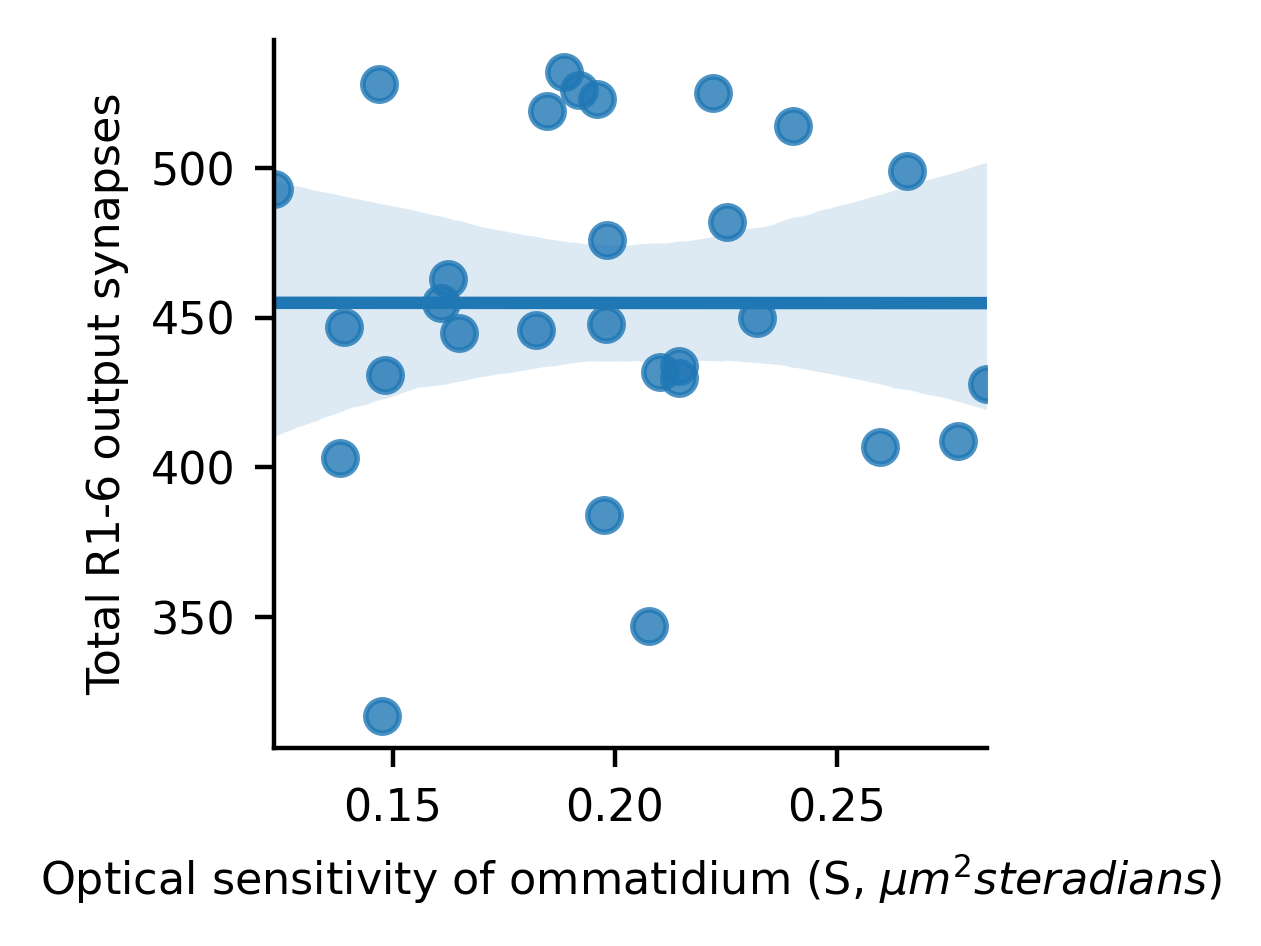

In [43]:
# S (overall) vs number of R1-6 syn outputs
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

ax = sns.regplot(x=optics_df['S'], y=cxvecs.filter(regex='^R').sum(axis=1))
plt.rcParams.update({"text.usetex": True})
ax.set_xlabel('Optical sensitivity of ommatidium (S, $\mu{m}^2 {steradians}$)')
plt.rcParams.update({"text.usetex": False})
ax.set_ylabel('Total R1-6 output synapses')

## Relative optical sensitivity of R1-6 (Land equation) vs. their outputs

In [36]:
# Calculate relative optical sensitivity of each R1-6 by multiplying the ommatidium's S with
# the fraction of the rhabdom's volume occupied by each rhabdomere
r_S = (optics_df['S'] * rb_frac.T).T
r_S.index = r_S.index.rename('pre_om')
r_S = r_S.reset_index()
r_S = r_S.melt(id_vars='pre_om').rename({'value': 'rel_S'}, axis=1)
r_S = r_S.loc[[i for i, p in r_S['rtype'].items() if p not in ['R7', 'R7p', 'R8']]]  # filter out long receptors

for i, row in r_S.iterrows():
    pre_name = f"om{row['pre_om']}_{row['rtype']}"
    #display(pre_name)
    r_S.loc[i, 'n_out_terms'] = r_out.loc[pre_name, 'n_out_terms']
    r_S.loc[i, 'n_out_syn'] = r_out.loc[pre_name, 'n_out_syn']

### Relative optical sensitivity vs. output synapses

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              n_out_syn   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     24.12
Date:                Thu, 24 Dec 2020   Prob (F-statistic):           2.09e-06
Time:                        17:58:50   Log-Likelihood:                -773.54
No. Observations:                 174   AIC:                             1551.
Df Residuals:                     172   BIC:                             1557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.4546      4.167     14.987      0.000      54.229      70.680
rel_S       1065.3815    216.913      4.912      0.000     637.228    1493.535
==============================================================================
Omnibus:                        2.435   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.296   Jarque-Bera (JB):                1.914
Skew:                           0.100   Prob(JB):                        0.384
Kurtosis:                       2.527   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

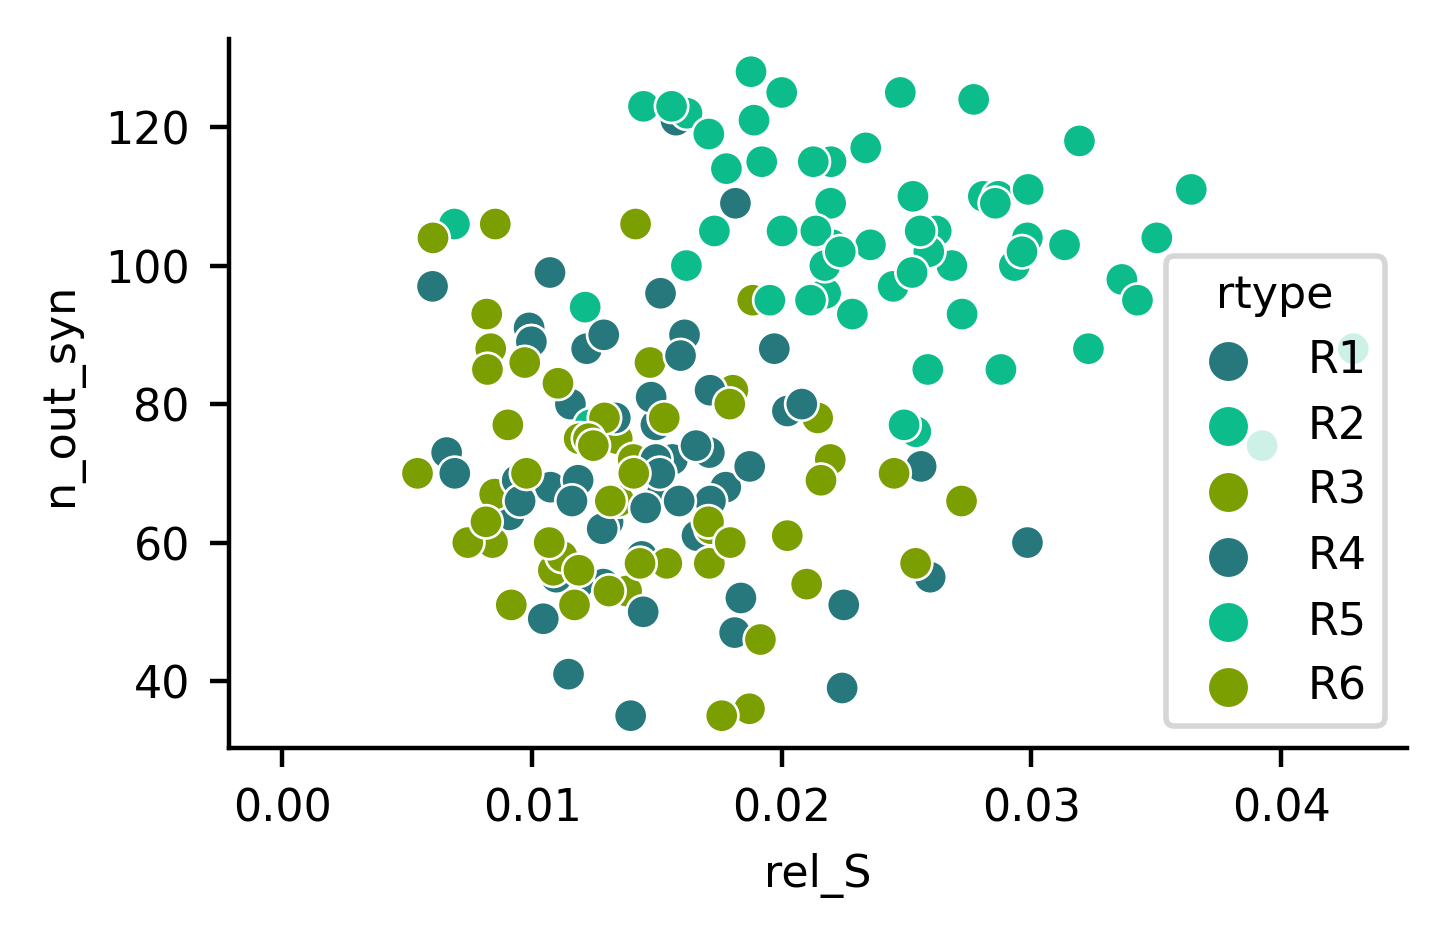

In [48]:
# OLS
_x = r_S['rel_S']
X = sm.add_constant(_x)
Y = r_S['n_out_syn']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

# Plot data/model
fig, ax = plt.subplots(1)
xx = np.arange(0, max(_x))

ax.plot(xx, params['const'] + params['rel_S'] * xx, c='k', ls='--')
sns.scatterplot(data=r_S, x='rel_S', y='n_out_syn', hue='rtype', palette=cm, ax=ax)


plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            n_out_terms   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     36.27
Date:                Thu, 24 Dec 2020   Prob (F-statistic):           1.01e-08
Time:                        17:59:39   Log-Likelihood:                -378.44
No. Observations:                 174   AIC:                             760.9
Df Residuals:                     172   BIC:                             767.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7155      0.430     17.934      0.000       6.866       8.565
rel_S        134.8762     22.394      6.023      0.000      90.674     179.079
==============================================================================
Omnibus:                        2.434   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.296   Jarque-Bera (JB):                2.093
Skew:                           0.260   Prob(JB):                        0.351
Kurtosis:                       3.133   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

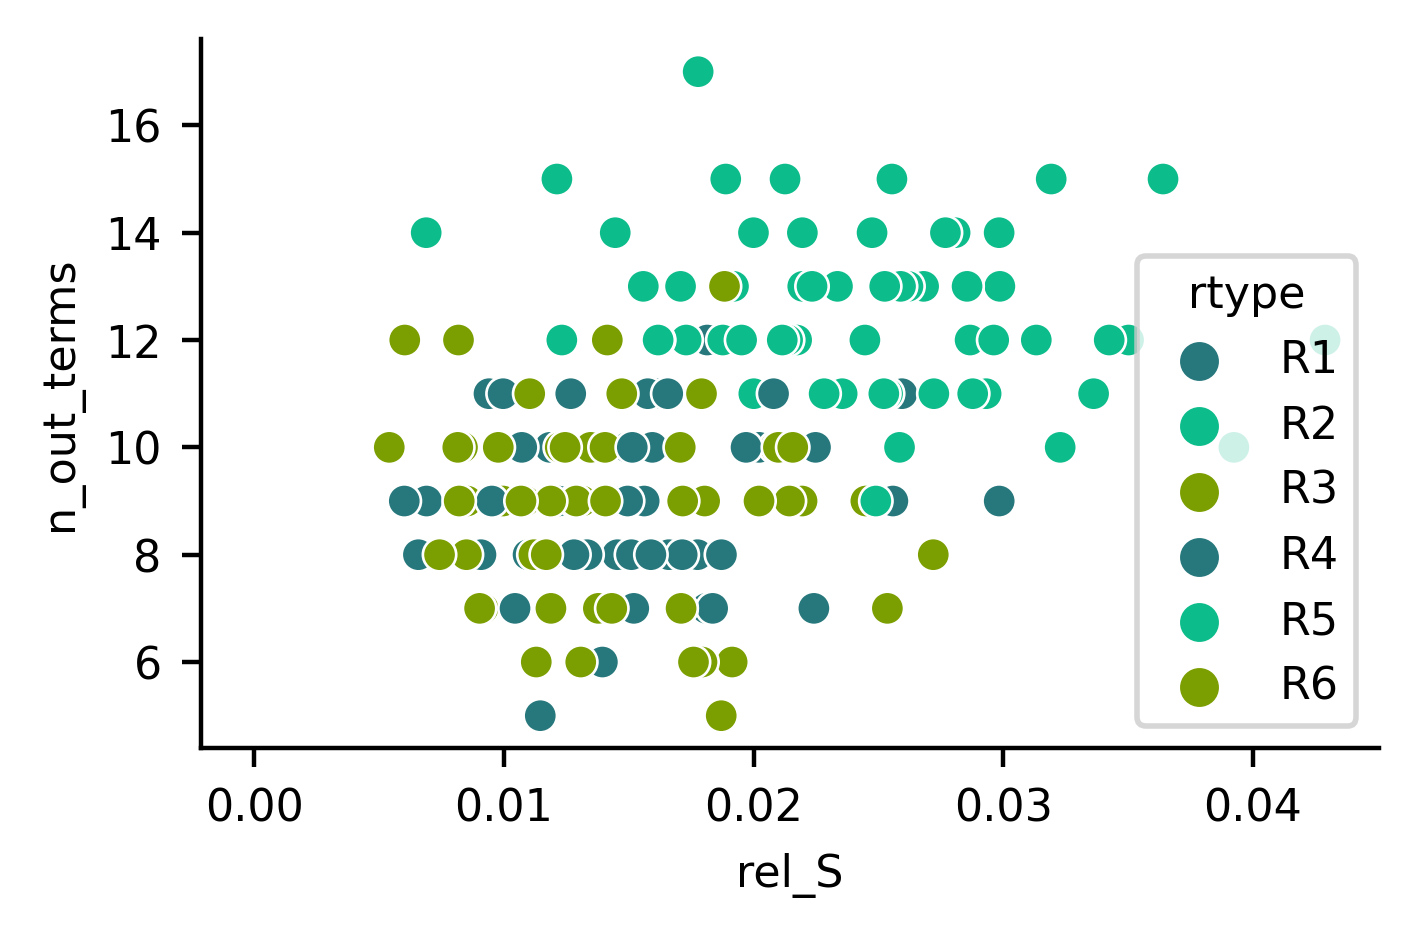

In [51]:
# OLS
_x = r_S['rel_S']
X = sm.add_constant(_x)
Y = r_S['n_out_terms']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

# Plot data/model
fig, ax = plt.subplots(1)
xx = np.arange(0, max(_x))

ax = sns.scatterplot(data=r_S, x='rel_S', y='n_out_terms', hue='rtype', palette=cm)

ax.plot(xx, params['const'] + params['rel_S'] * xx, c='k')
plt.show()